In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
font_plot = {'fontname':'Times New Roman', 'size':15}
font_plot_t = {'fontname':'KaiTi', 'size':18, 'color':'blue'}
font_plot_s = {'fontname':'Microsoft YaHei', 'size':14}

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels, **font_plot_s)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)
                
        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)
            
        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)
    register_projection(RadarAxes)
    return theta

table_all = pandas.read_excel('bb_evaluation.xlsx')
groups = set(table_all['group'].unique())
fleets = set(table_all['fleet'].unique())

def bb_skill(player_group):
    if player_group in groups:
        classifier = 'group'
    elif player_group in fleets:
        classifier = 'fleet'
    table = table_all[table_all[classifier]==player_group]
    player_data = table[['position','offense','aa','awareness','scout_c','defense']].values.tolist()
    player_id = table['id'].values.tolist()
    data = [['走位', '进攻', '防空', '意识', '控侦', '防守']]
    data.append(('BB玩家超级房战斗力对比图', player_data))
    N = len(data[0])
    theta = radar_factory(N, frame='polygon')
    spoke_labels = data.pop(0)
    title, case_data = data[0]
    fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(top=0.85, bottom=0.05)
    # ax.set_rgrids([0.2, 0.4, 0.6, 0.8],**font_plot)
    ax.yaxis.grid(False)
    ax.set_yticklabels([])
    ax.set_title(title,  position=(0.5, 1.1), ha='center', **font_plot_t)
    for d in case_data:
        line = ax.plot(theta, d)
        ax.fill(theta, d,  alpha=0.25)
    ax.set_varlabels(spoke_labels)
    ax.set_ylim(0, 1)
    labels = tuple(player_id)
    ax.legend(labels, loc=(1.2,0.5), fontsize=16)
    plt.show()

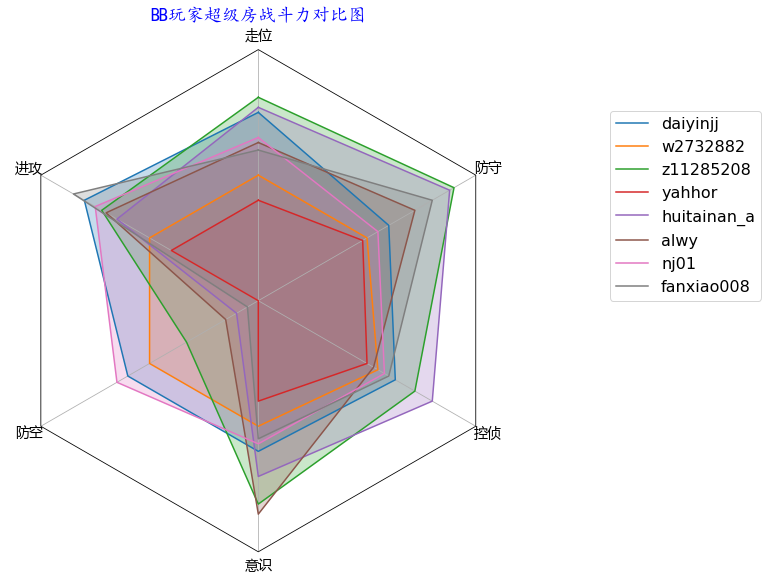

In [2]:
# 随机名字群
bb_skill('random')

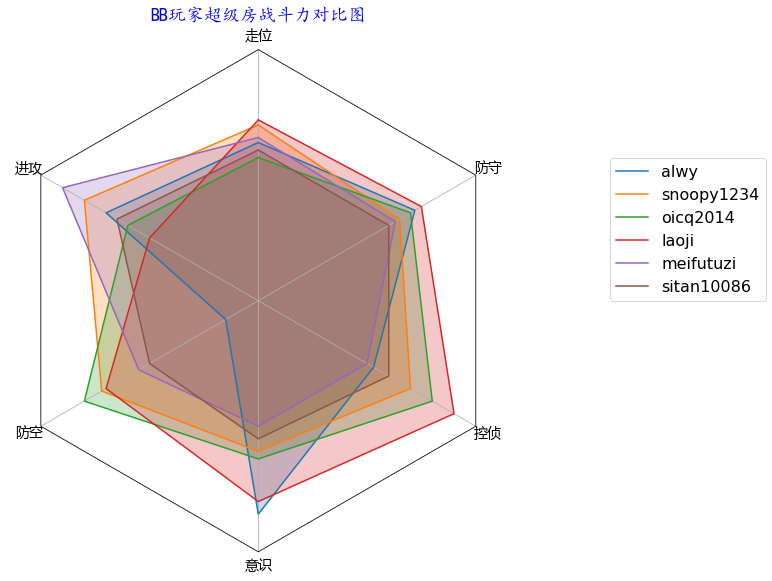

In [3]:
# 兔子群
bb_skill('mitao')

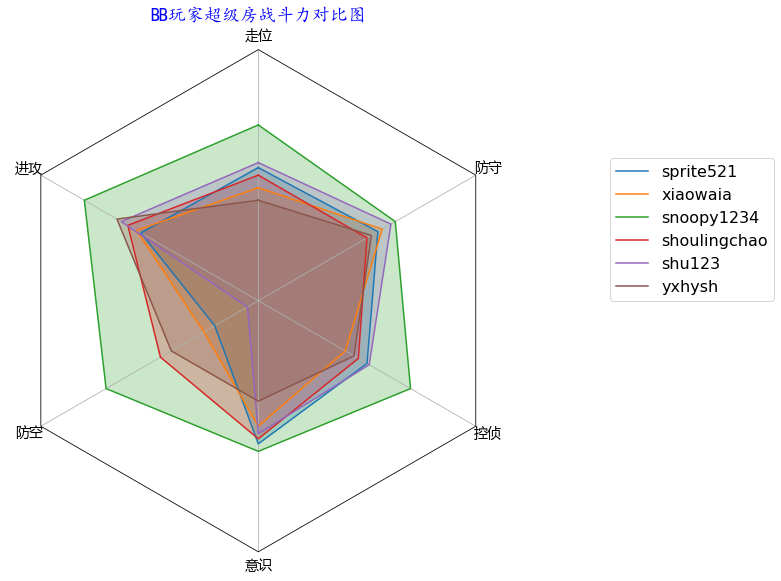

In [4]:
# 深海快反群
bb_skill('shenhai')